#### Imports and Installs

In [1]:
# Installs
!pip install -q rich markdown-it-py tensorflow-cpu tensorflow gym==0.21.0 torch==2.0.1 numpy keras python-binance seaborn ipykernel stable-baselines3[extra] tensorboard scikit-learn

In [2]:
# Imports
# System utils 
from IPython.core.interactiveshell import InteractiveShell

# Data Processing
import pandas as pd

# Plotting
import matplotlib.pyplot as plt 

# Reinforcement Learning
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from tradinggym import CryptoEnvironment

# NB Setup
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('dark_background')

#### Load and Visualize Data

In [3]:
# Load data from disk
# Make sure there is lots of data as padding is finnicky due to batch normalization and forward-looking reward calculation
data = pd.read_pickle('./data/measurement.pickle')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,Open,High,Low,Close,Volume,taker_buy_quote_asset_volume,AROON,%D,KCU,KCL,FI,DIFFRSI,SRSI,TRIX_HIST,AO
open_time,,,,,,,,,,,,,,,
1641028200000,47142.39,47142.39,47142.39,47142.39,0.000000,0.000000,-50.0,25.179543,47170.9185,47170.9185,-29.604093,2.268637,0.921130,0.000172,10.694618
1641028500000,47142.39,47142.39,47142.02,47142.02,0.003924,0.000000,-50.0,28.406955,47176.5515,47175.0715,-30.705597,2.268637,0.870136,0.000120,8.697912
1641028800000,47142.02,47142.02,47142.02,47142.02,0.000000,0.000000,-50.0,28.360903,47179.2515,47179.2515,-36.811017,2.268637,0.898510,0.000091,12.269794
1641029100000,47103.27,47124.42,47103.27,47124.42,0.006091,286.978747,-50.0,26.124242,47222.5195,47137.9195,-21.958556,1.749303,1.000000,-0.000079,15.217794
1641029400000,47112.96,47118.73,47112.96,47118.73,0.031840,0.000000,-50.0,23.225421,47190.9215,47167.8415,-24.834712,1.749303,0.948227,-0.000038,13.979676


(144634, 15)

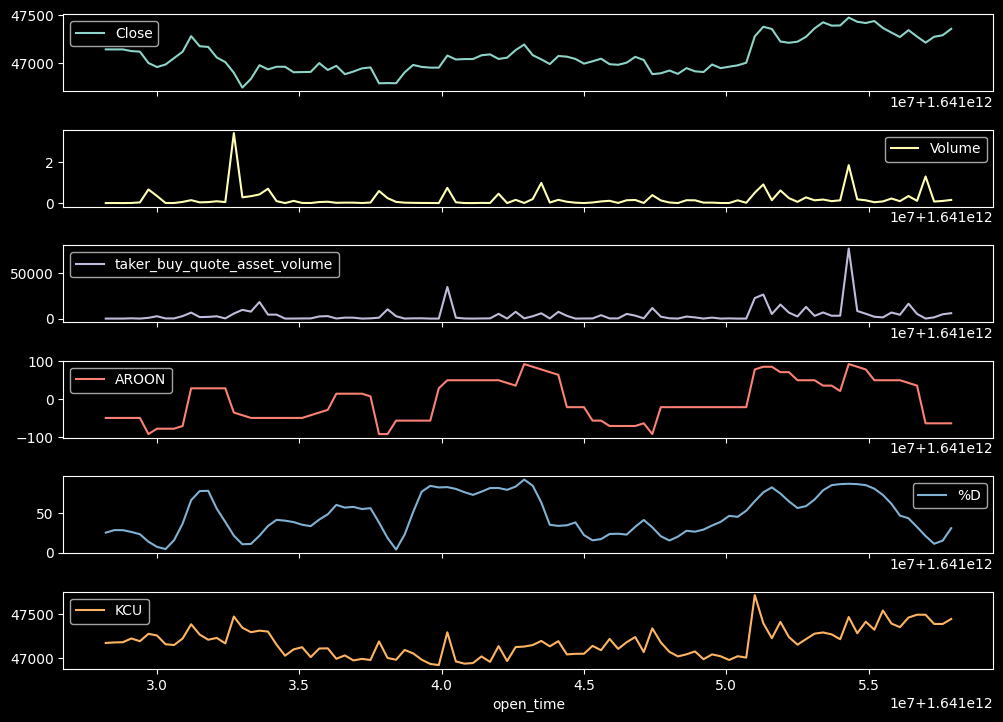

In [4]:
# Visual EDA, show subplots vertically
ax = data[data.columns[3:9]][:100].plot(subplots=True, layout=(len(data.columns), 1), figsize=(12, 22));
plt.subplots_adjust(hspace=0.5);
plt.legend(loc='upper right', bbox_to_anchor=(0,0), ncol=1);
data.head()
data.shape

#### Set up Environment

In [5]:
# Create the CryptoEnvironment instance
window_size = 10
env = CryptoEnvironment(observations=data, initial_value = 10000, window_size=window_size, order_fraction=0.66, trade_fee=0.003375)

# Wrap the environment in a vectorized form
env = DummyVecEnv([lambda: env])
%load_ext tensorboard


#### Create Agent

In [6]:
# Create the agent

model = PPO('MlpPolicy',env,verbose=1,n_steps=64,gamma=0.5,ent_coef=0.5, learning_rate = 0.0001,
            tensorboard_log="./tensorboard/CryptoEnvironment") # Create model
model.save("./models/PPO/trading_model_orig.torch") # Save model
del model # Delete model to demonstrate how to load
model = PPO.load('./models/PPO/trading_model_orig.torch', env=env) # Load model

Using cpu device


#### Train Agent

In [7]:
%%capture
# Train agent
for i in range(1):
    model.learn(total_timesteps=1000,reset_num_timesteps=False)
    model.save('./models/PPO/' + 'trading_model_chkpt_orig' + '.torch')

#### Evaluate Agent

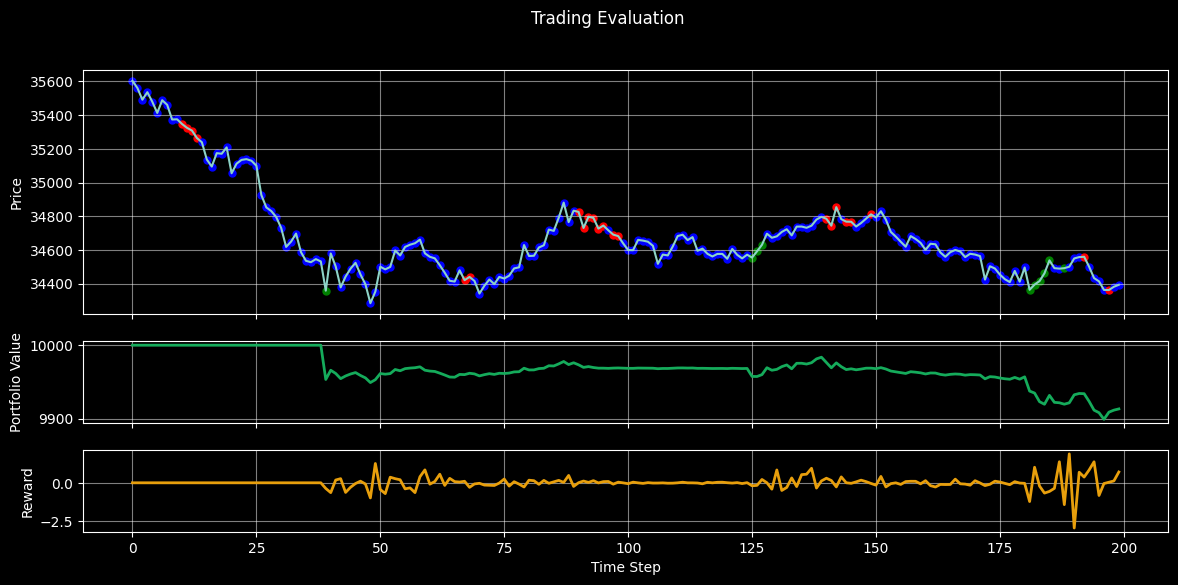

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         9929.66
Profit:              -70.34
Return Rate:         -0.70%
Cumulative reward:   0.54
Max reward:          1.89
Min reward:          -2.95


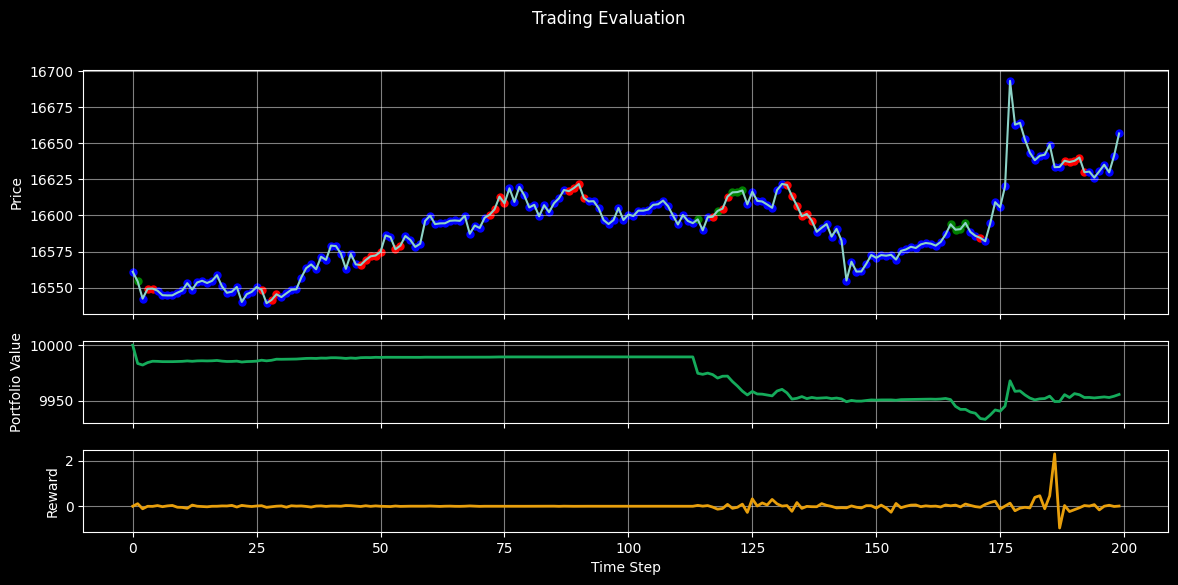

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         9961.27
Profit:              -38.73
Return Rate:         -0.39%
Cumulative reward:   2.45
Max reward:          2.30
Min reward:          -0.96


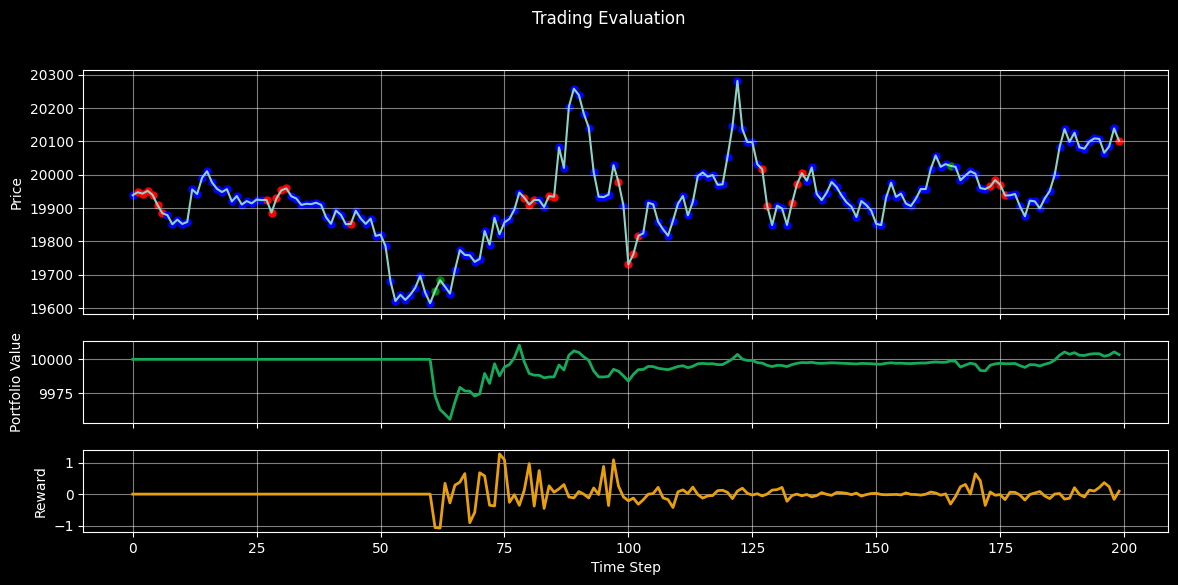

Evaluation Metrics:  
Initial balance:     10000.00
Final value:         10005.87
Profit:              5.87
Return Rate:         0.06%
Cumulative reward:   4.16
Max reward:          1.28
Min reward:          -1.08


In [8]:
# Test the trained agent
for i in range(3):
    # Params
    initial_value = 10000 # Initial balance to trade with, split randomly between assets and cash
    window_size = 10 
    frame_length = 50  # Length of the evaluation subset

    # Create the CryptoEnvironment instance
    testenv = CryptoEnvironment(initial_value = 10000, observations = data, window_size=window_size, trade_fee=0.003375)

    # Evaluate the model
    testenv.evaluate(frame_length=200, render=True, model=model, marker_size = 25, verbose=1);